# MAHTS generation

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import deacoastlines_generation as dcl_gen

import os
import sys
import datacube
import geopandas as gpd
import multiprocessing
import xarray as xr
from functools import partial

sys.path.append('../Scripts')
from dea_plotting import display_map

dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='3gb')
display(client)

import datetime
start_time = datetime.datetime.now()

Client Scheduler: tcp://127.0.0.1:37710 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


### Load supplementary data

In [2]:
# Tide points are used to model tides across the extent of the satellite data
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

# Albers grid cells used to process the analysis
gridcell_gdf = (gpd.read_file('input_data/50km_albers_grid_clipped.shp')
            .to_crs(epsg=4326)
            .set_index('id'))

## Loading data
### Create query


In [4]:
study_area = 2523
output_name = 'test'

# If output folder doesn't exist, create it
output_dir = f'output_data/{study_area}_{output_name}'
os.makedirs(output_dir, exist_ok=True)
    
study_area_geopoly = dcl_gen.get_geopoly(study_area, gridcell_gdf)
query = {'geopolygon': study_area_geopoly,
         'time': ('2015', '2019'),
         'cloud_cover': [0, 90],
         'dask_chunks': {'time': 1, 'x': 1000, 'y': 1000}}

# Preview study area
display_map(x=(query['geopolygon'].envelope.left, 
               query['geopolygon'].envelope.right), 
            y=(query['geopolygon'].envelope.top, 
               query['geopolygon'].envelope.bottom))


### Load virtual product

In [5]:
# Load virtual product    
ds = dcl_gen.load_mndwi(dc, 
                        query, 
                        yaml_path='deacoastlines_virtual_products.yaml',
                        virtual_products=False)
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 338 time steps as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


<xarray.Dataset>
Dimensions:  (time: 338, x: 1747, y: 1062)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T01:41:09.761652 ... 2019-08-16T01:28:19.277160
  * y        (y) float64 -3.739e+06 -3.739e+06 ... -3.771e+06 -3.771e+06
  * x        (x) float64 4.256e+05 4.256e+05 4.256e+05 ... 4.779e+05 4.78e+05
Data variables:
    mndwi    (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    tcb      (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:      epsg:32651

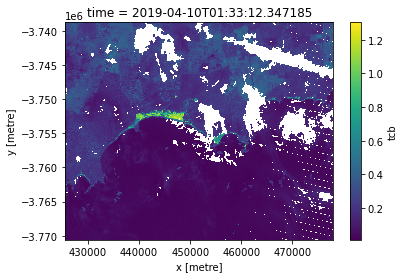

In [14]:
ds.isel(time=317).tcb.plot()

## Tidal modelling
### Model tides at point locations

In [15]:
tidepoints_gdf = dcl_gen.model_tides(ds, points_gdf)

### Interpolate tides into each satellite timestep

In [16]:
pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)
print(f'Parallelising {multiprocessing.cpu_count() - 1} processes')
out_list = pool.map(partial(dcl_gen.interpolate_tide,
                      tidepoints_gdf=tidepoints_gdf,
                      factor=50), 
                    iterable=[(group.x.values, 
                               group.y.values, 
                               group.time.values) 
                              for (i, group) in ds.groupby('time')])

# Combine to match the original dataset
ds['tide_m'] = xr.concat(out_list, dim=ds['time'])

Parallelising 7 processes


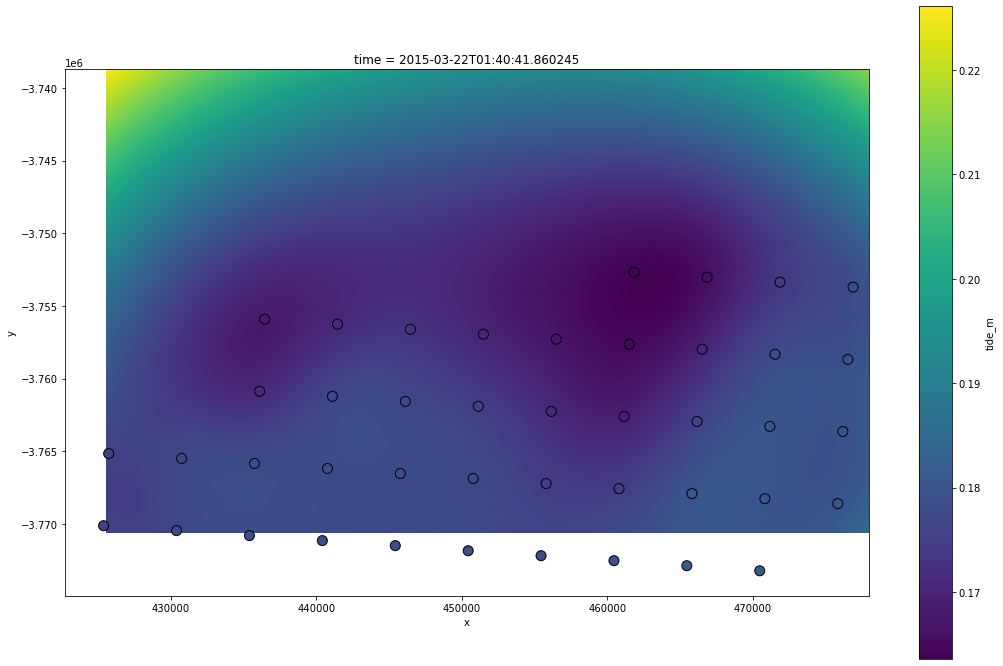

In [17]:
import matplotlib.pyplot as plt

# Plot 
ds_i = ds['tide_m'].isel(time=18).compute()
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(),
                                                     vmax=ds_i.max().item())


In [18]:
# Determine tide cutoff
tide_cutoff_buff = (
    (ds['tide_m'].max(dim='time') - ds['tide_m'].min(dim='time')) * 0.25)
tide_cutoff_min = 0.0 - tide_cutoff_buff
tide_cutoff_max = 0.0 + tide_cutoff_buff

## Generate yearly composites

In [19]:
# Iterate through each year and export annual and 3-year gapfill composites
dcl_gen.export_annual_gapfill(ds, 
                              output_dir, 
                              tide_cutoff_min, 
                              tide_cutoff_max)

Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019


In [ ]:
output_dir

In [ ]:
print(f'{(datetime.datetime.now() - start_time).seconds / 60:.1f} minutes')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020